<a href="https://colab.research.google.com/github/koushikchimakurthi/cats_dogs_classification/blob/master/CatsvsDogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
import seaborn as sns
sns.set()
import random
from shutil import copyfile

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
!wget --no-check-certificate \
    "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip" \
    -O "/tmp/cats-and-dogs.zip"

--2020-09-08 13:42:57--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.52.161.19, 2600:1402:800:184::e59, 2600:1402:800:189::e59
Connecting to download.microsoft.com (download.microsoft.com)|23.52.161.19|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824894548 (787M) [application/octet-stream]
Saving to: ‘/tmp/cats-and-dogs.zip’

/tmp/cats-and-dogs. 100%[===================>] 786.68M   100MB/s    in 8.2s    

2020-09-08 13:43:06 (96.4 MB/s) - ‘/tmp/cats-and-dogs.zip’ saved [824894548/824894548]



In [3]:
import zipfile
import os
local_zip = '/tmp/cats-and-dogs.zip'
with zipfile.ZipFile(local_zip, 'r') as zipref:
  zipref.extractall('/tmp')
  zipref.close()

In [4]:
try:
    os.mkdir('/tmp/cats-v-dogs')
    os.mkdir('/tmp/cats-v-dogs/training')
    os.mkdir('/tmp/cats-v-dogs/testing')
    os.mkdir('/tmp/cats-v-dogs/training/cats')
    os.mkdir('/tmp/cats-v-dogs/training/dogs')
    os.mkdir('/tmp/cats-v-dogs/testing/cats')
    os.mkdir('/tmp/cats-v-dogs/testing/dogs')
except OSError:
    pass

In [5]:
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
  files = []
  for filename in os.listdir(SOURCE):
    file = SOURCE + filename
    if os.path.getsize(file)>0:
      files.append(filename)
    else:
      print("{} is zero length, so ignoring..".format(filename)) 

  training_length = int(len(files) * SPLIT_SIZE)
  testing_length = int(len(files) - training_length)
  shuffled_set = random.sample(files, len(files))
  training_set = shuffled_set[0:training_length]
  testing_set = shuffled_set[-testing_length:]

  for filename in training_set:
    this_file = SOURCE + filename
    destination = TRAINING + filename
    copyfile(this_file, destination)
  
  for filename in testing_set:
    this_file = SOURCE + filename
    destination = TESTING + filename
    copyfile(this_file, destination)

CAT_SOURCE_DIR = "/tmp/PetImages/Cat/"
TRAINING_CATS_DIR = "/tmp/cats-v-dogs/training/cats/"
TESTING_CATS_DIR = "/tmp/cats-v-dogs/testing/cats/"
DOG_SOURCE_DIR = "/tmp/PetImages/Dog/"
TRAINING_DOGS_DIR = "/tmp/cats-v-dogs/training/dogs/"
TESTING_DOGS_DIR = "/tmp/cats-v-dogs/testing/dogs/"

split_size = .9
split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, TESTING_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, TESTING_DOGS_DIR, split_size)

666.jpg is zero length, so ignoring..
11702.jpg is zero length, so ignoring..


In [6]:
train_datagen = ImageDataGenerator(rescale=1/255)
train_generator = train_datagen.flow_from_directory('/tmp/cats-v-dogs/training/',
                                                    target_size = (150,150),
                                                    batch_size = 64,
                                                    class_mode = 'binary')
validation_datagen = ImageDataGenerator(rescale=1/255)
validation_generator = validation_datagen.flow_from_directory('/tmp/cats-v-dogs/testing/',
                                                              target_size = (150,150),
                                                              batch_size = 32,
                                                              class_mode = 'binary')

Found 24748 images belonging to 2 classes.
Found 4750 images belonging to 2 classes.


In [7]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer=keras.optimizers.RMSprop(lr=0.001), loss='binary_crossentropy', metrics=['acc'])

In [8]:
class my_callback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs = {}):
    if logs.get('val_acc')>0.90:
      print("Accuracy reached 90%, stopping training..")
      self.model.stop_training = True

In [9]:
history = model.fit(train_generator, epochs=15, steps_per_epoch=90,
                    validation_data=validation_generator, validation_steps=6, callbacks = [my_callback()])

Epoch 1/15
90/90 [==============================] - 21s 231ms/step - loss: 0.7469 - acc: 0.5843 - val_loss: 0.6567 - val_acc: 0.5990
Epoch 2/15
90/90 [==============================] - 20s 222ms/step - loss: 0.6126 - acc: 0.6668 - val_loss: 0.5604 - val_acc: 0.7188
Epoch 3/15
90/90 [==============================] - 20s 224ms/step - loss: 0.5629 - acc: 0.7132 - val_loss: 0.5945 - val_acc: 0.6823
Epoch 4/15
90/90 [==============================] - 20s 225ms/step - loss: 0.5313 - acc: 0.7368 - val_loss: 0.4480 - val_acc: 0.7604
Epoch 5/15
90/90 [==============================] - 20s 223ms/step - loss: 0.4847 - acc: 0.7637 - val_loss: 0.4326 - val_acc: 0.7812
Epoch 6/15
90/90 [==============================] - 20s 221ms/step - loss: 0.4641 - acc: 0.7793 - val_loss: 0.4130 - val_acc: 0.8021
Epoch 7/15
90/90 [==============================] - 20s 219ms/step - loss: 0.4498 - acc: 0.7884 - val_loss: 0.5055 - val_acc: 0.7604
Epoch 8/15
90/90 [==============================] - 20s 218ms/step - 

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

90/90 [==============================] - 21s 230ms/step - loss: 0.3547 - acc: 0.8483 - val_loss: 0.2642 - val_acc: 0.9167


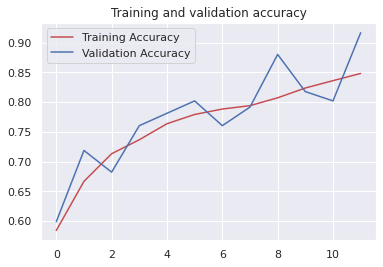

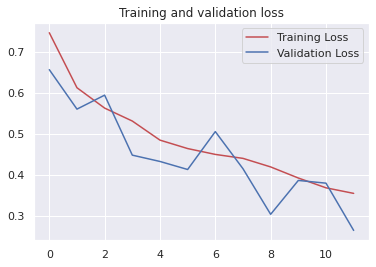

In [10]:
acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']
epochs=range(len(acc))
plt.plot(epochs, acc, 'r', label = "Training Accuracy")
plt.plot(epochs, val_acc, 'b', label = "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.legend()
plt.show()
plt.plot(epochs, loss, 'r', label ="Training Loss")
plt.plot(epochs, val_loss, 'b', label = "Validation Loss")
plt.title('Training and validation loss')
plt.legend()
plt.show()